In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
import os
import sys
import copy
import json
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, os.path.join(root, 'simclr'))
import metrics
import model as model_lib
from utils import get_files_and_labels, get_tf_dataset, read_class_label_map

from absl import logging
logging.set_verbosity(logging.ERROR)

2021-07-29 08:54:12.599023: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Define core eval logic

In [4]:
def perform_evaluation(model, ds, num_classes, ckpt, model_dir, strategy=None, batch_size=256):
    """Evaluates the given model at a given checkpoint on the provided (test) data set."""
    summary_writer = tf.summary.create_file_writer(model_dir)

    # Build metrics
    # TODO: Use scopes
    supervised_loss = tf.keras.metrics.SparseCategoricalCrossentropy(
        from_logits=True, name='eval/supervised_loss')
    label_top_1_accuracy = tf.keras.metrics.Accuracy(
        'eval/label_top_1_accuracy')
    label_top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
        5, 'eval/label_top_5_accuracy')
    all_metrics = [supervised_loss, label_top_1_accuracy, label_top_5_accuracy]

    # Restore checkpoint
    print(f"Restoring from {ckpt}")
    checkpoint = tf.train.Checkpoint(
        model=model, global_step=tf.Variable(0, dtype=tf.int64))
    status = checkpoint.restore(ckpt).expect_partial()
    global_step = checkpoint.global_step
    print(f"Performing eval at step {global_step.numpy()}")

    # Compile model
    model.compile(
        metrics=all_metrics
    )

    def eval_step(X, y):
        """Makes predictions on images and updates metrics"""
        labels = y  # tf.one_hot(y, num_classes)
        _, supervised_head_outputs = model(X, training=False)
        assert supervised_head_outputs is not None
        logits = supervised_head_outputs
        metrics.update_finetune_metrics_eval(
            label_top_1_accuracy,
            label_top_5_accuracy,
            logits,
            labels
        )
        supervised_loss.update_state(labels, logits)
        return logits, labels

    logits = []
    labels = []
    temp_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    for it, (X, y) in enumerate(iter(temp_ds)):
        logits_, labels_ = eval_step(X, y)
        logits.append(logits_.numpy())
        labels.append(labels_)
    logits = np.concatenate(logits)
    labels = np.concatenate(labels)
    predictions = np.argmax(logits, axis=1)

    # Write summaries
    result_json_path = os.path.join(model_dir, 'result.json')
    result = {metric.name: metric.result().numpy() for metric in all_metrics}
    result['global_step'] = global_step.numpy()
    print(result)
    with tf.io.gfile.GFile(result_json_path, 'w') as f:
        json.dump({k: float(v) for k, v in result.items()}, f)

    return logits, predictions, labels

# Prepare (test) dataset

Set up the appropriate directories and use helper functions in `simclr.utils` to generate a TensorFlow Dataset

In [5]:
root = os.path.dirname(os.path.abspath(''))  # simclr-experiments folder
data_dir = os.path.join(root, 'data', 'msl-labeled-data-set-v2.1')
img_folder = os.path.join(data_dir, 'images')
file_list = os.path.join(data_dir, 'test-set-v2.1.txt')
class_mapping = read_class_label_map(
    os.path.join(data_dir, 'class_map.csv'))

X, num_files, num_classes, class_mapping = get_files_and_labels(
    img_folder, ext="jpg", metadata_file=file_list, mapping=class_mapping
)

image_size = 227
test_ds = get_tf_dataset(
    X, "jpg", preprocess=True, width=image_size, height=image_size)

2021-07-29 08:54:20.504174: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-29 08:54:22.012918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-29 08:54:22.015326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:07:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-07-29 08:54:22.033149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:0a:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2

# Define plotting functions

Note that this needs to happen after `read_class_label_map` defines the `class_mapping` dict.

In [6]:
classes = list(class_mapping.keys())


def plot_confusion_matrix(y_true, y_pred, ckpt):
    fig, ax = plt.subplots(figsize=(14, 10))

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=classes)
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    accuracy = sklearn.metrics.accuracy_score(
        y_true, y_pred, sample_weight=None)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'

    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.0f')
    ax.set_title(
        f"Finetuned on full training data (2900 images) - overall accuracy: {100*accuracy:.2f}%")

    plt.tight_layout()
#     plt.savefig(f"{ckpt}_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cm, accuracy


def set_font_size(ax, fontsize=12):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)


def plot_precision_vs_recall(y_true, y_pred, ckpt):
    fig, ax = plt.subplots(figsize=(10, 8))

    cr = sklearn.metrics.classification_report(
        y_true, y_pred, labels=classes, output_dict=True)
    cr_df = pd.DataFrame.from_dict(cr).T

    # add "num_samples" column to classification report - should be equivalent to "Support" column
    num_examples = pd.DataFrame(
        pd.DataFrame(
            [classes[x[1]] for x in X],
            columns=['class']).value_counts(),
        columns=['num_samples']
    ).reset_index()    
    cr_df_with_counts = pd.merge(num_examples, cr_df.reset_index().rename(
        columns={'index': 'class'}), how='inner')

    mean_precision = cr_df.loc['macro avg', 'precision']
    mean_recall = cr_df.loc['macro avg', 'recall']
    mean_f1 = cr_df.loc['macro avg', 'f1-score']

    class_order = [
        'Arm cover', 'Other rover part', 'Artifact', 'Nearby surface',
        'Close-up rock', 'DRT', 'DRT spot', 'Distant landscape', 'Drill hole',
        'Night sky', 'Float', 'Layers', 'Light-toned veins', 'Mastcam cal target',
        'Sand', 'Sun', 'Wheel', 'Wheel joint', 'Wheel tracks'
    ]
    marker_order = [
        "o", "v", "^", "<", ">", "o", "s", "P", "p", "*", "X", "D", "d", "h", "H", "1", "2", "3", "4"
    ]
    kiri_markers = {c: m for c, m in zip(class_order, marker_order)}
    colors = list(plt.get_cmap('tab20').colors)
    colors.pop(class_order.index('Night sky'))

    cr_df_with_counts = cr_df_with_counts.sort_values(
        by='class', key=lambda x: [class_order.index(xx) for xx in x])
    for i in range(0, len(cr_df_with_counts)):
        x = cr_df_with_counts.iat[i, 3]  # recall
        y = cr_df_with_counts.iat[i, 2]  # precision
        cls = cr_df_with_counts.iat[i, 0]  # class
        n_min, n_max = cr_df_with_counts['num_samples'].min(
        ), cr_df_with_counts['num_samples'].max()
        s = 95
        alpha = 0.5 if np.isclose(x, 0) and np.isclose(y, 0) else 1
        label = cls + ' (at [0, 0])' if np.isclose(x,
                                                   0) and np.isclose(y, 0) else cls
        ax.scatter(x, y, s=s, c=[colors[i]],
                   marker=kiri_markers[cls], label=label, alpha=alpha)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim((-0.04, 1.04))
    ax.set_ylim((-0.04, 1.04))
    plt.grid(linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    set_font_size(ax, 14)
    plt.tight_layout()
    ax.set_aspect(1.)
    ax.text(
        x=0.65,
        y=0.05,
        s=(f"Mean precision: {mean_precision*100:.2f} %\n"
           f"Mean recall: {mean_recall*100:.2f} %\n"
           f"Mean F1: {mean_f1*100:.2f} %")
    )

#     plt.savefig(f"{ckpt}_precision_recall_test.png", transparent=True, bbox_inches='tight')
    plt.show()
    return fig, ax, cr_df_with_counts, mean_precision, mean_recall

# Create model instance and set up checkpoint paths

Must update everything so that model params match those used in `model_dir/model_str/config.json`

In [7]:
resnet_depth = 152
width_multiplier = 2
sk_ratio = 0.0625
num_proj_layers = 3
proj_out_dim = 128
model_dir = '/home/goh/Documents/D3M/mars_simclr_models'
dataset = 'mars_v2_weighted_loss'

# Set up checkpoint directory
timestamp = '2021-07-27_0718'
model_substr = f"r{resnet_depth}_{width_multiplier}x_sk{int(sk_ratio > 0)}"
model_str = f"finetune_{dataset}_{model_substr}_proj{proj_out_dim}_{num_proj_layers}projLayers"
log_name = f"{model_str}_{timestamp}"
checkpoint = f'/home/goh/Documents/D3M/simclr_tf2_models/pretrained/{model_substr}/saved_model'
model_dir = os.path.join(model_dir, log_name)
print(
    f"model_substr = {model_substr}\n"
    f"model_str = {model_str}\n"
    f"model_dir = {model_dir}\n"
    f"log_name = {log_name}\n"
    f"checkpoint = {checkpoint}"
)
with tf.device('/gpu:0'):  # can choose which gpu to run this
    model = model_lib.Model(
        num_classes,
        image_size,
        train_mode="finetune",
        optimizer_name="lars",
        weight_decay=0,
        resnet_depth=resnet_depth,
        sk_ratio=sk_ratio,
        width_multiplier=width_multiplier,
        proj_out_dim=proj_out_dim,
        num_proj_layers=num_proj_layers,
        ft_proj_selector=0,
        head_mode="nonlinear",
        fine_tune_after_block=3,
        linear_eval_while_pretraining=False,
    )

    model.build((None, image_size, image_size, 3))
    model.summary()

model_substr = r152_2x_sk1
model_str = finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers
model_dir = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718
log_name = finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718
checkpoint = /home/goh/Documents/D3M/simclr_tf2_models/pretrained/r152_2x_sk1/saved_model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet (Resnet)              multiple                  353752896 
_________________________________________________________________
projection_head (ProjectionH multiple                  34111872  
_________________________________________________________________
head_supervised (SupervisedH multiple                  77843     
Total params: 387,942,611
Trainable params: 122,894,867
Non-trainable params: 265,047,744
_________________

# Evaluate each checkpoint saved in `model_dir`

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-40
Performing eval at step 0


2021-07-29 09:04:09.198595: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-29 09:04:09.223636: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2195030000 Hz
2021-07-29 09:04:10.320943: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-29 09:04:12.257756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2021-07-29 09:04:14.986235: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-29 09:04:17.427105: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


{'eval/supervised_loss': 1.1603564, 'eval/label_top_1_accuracy': 0.785, 'eval/label_top_5_accuracy': 0.9683333, 'global_step': 0}


<IPython.core.display.Javascript object>


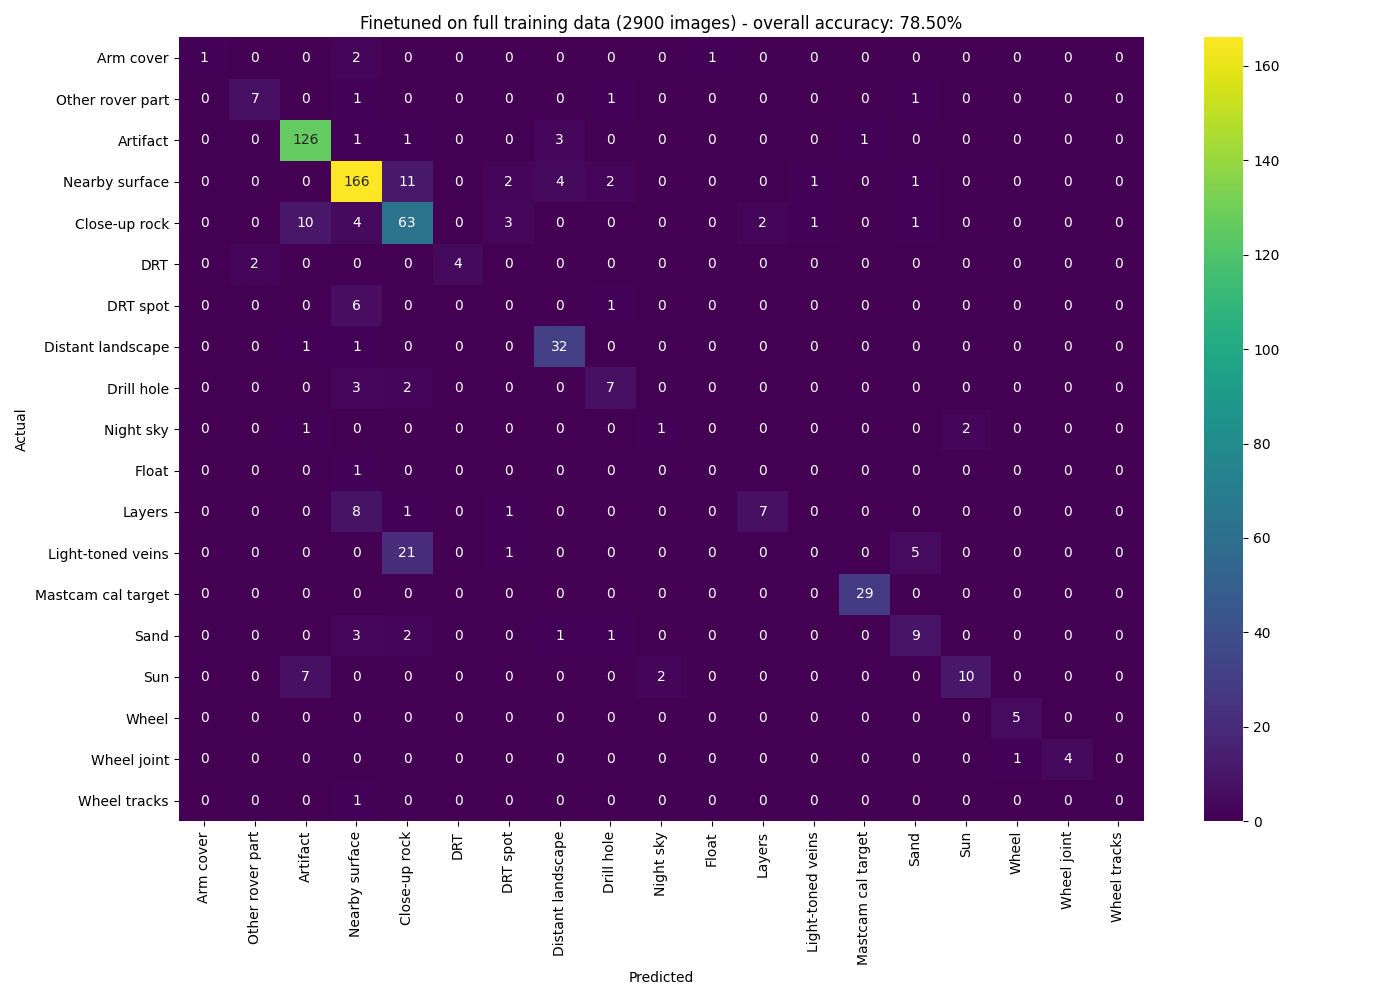

<IPython.core.display.Javascript object>


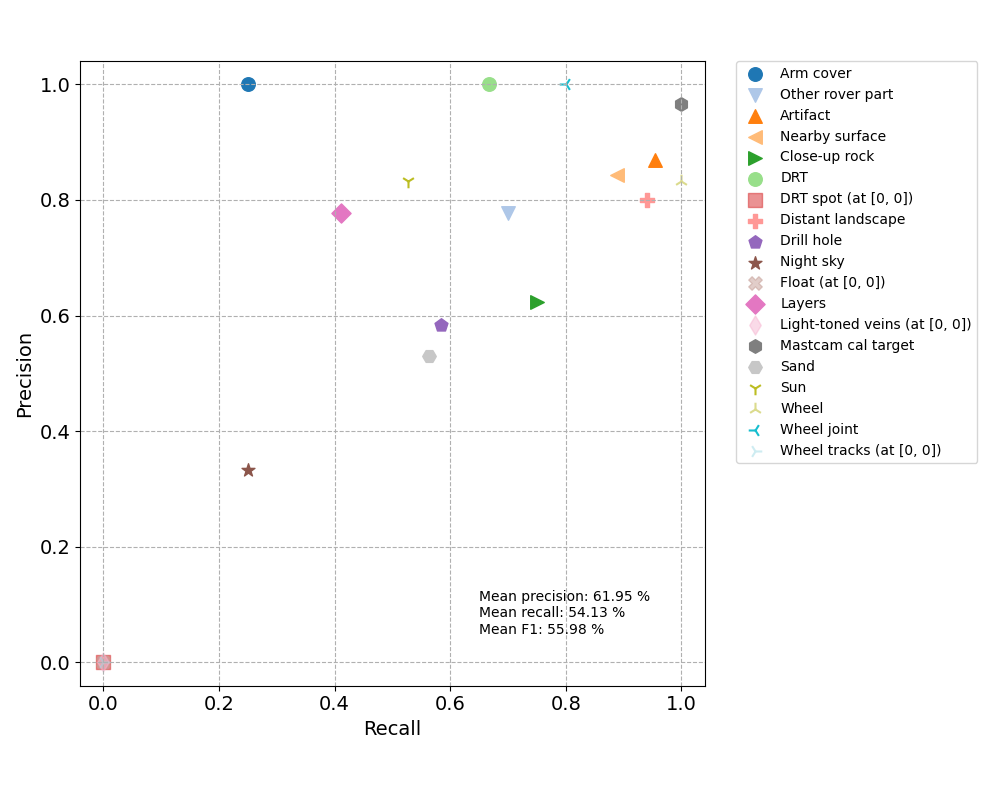

/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-40
 acc = 78.50
 mean_precision = 61.95
mean_recall = 54.13

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-41
Performing eval at step 0
{'eval/supervised_loss': 1.1426501, 'eval/label_top_1_accuracy': 0.795, 'eval/label_top_5_accuracy': 0.96666664, 'global_step': 0}


<IPython.core.display.Javascript object>


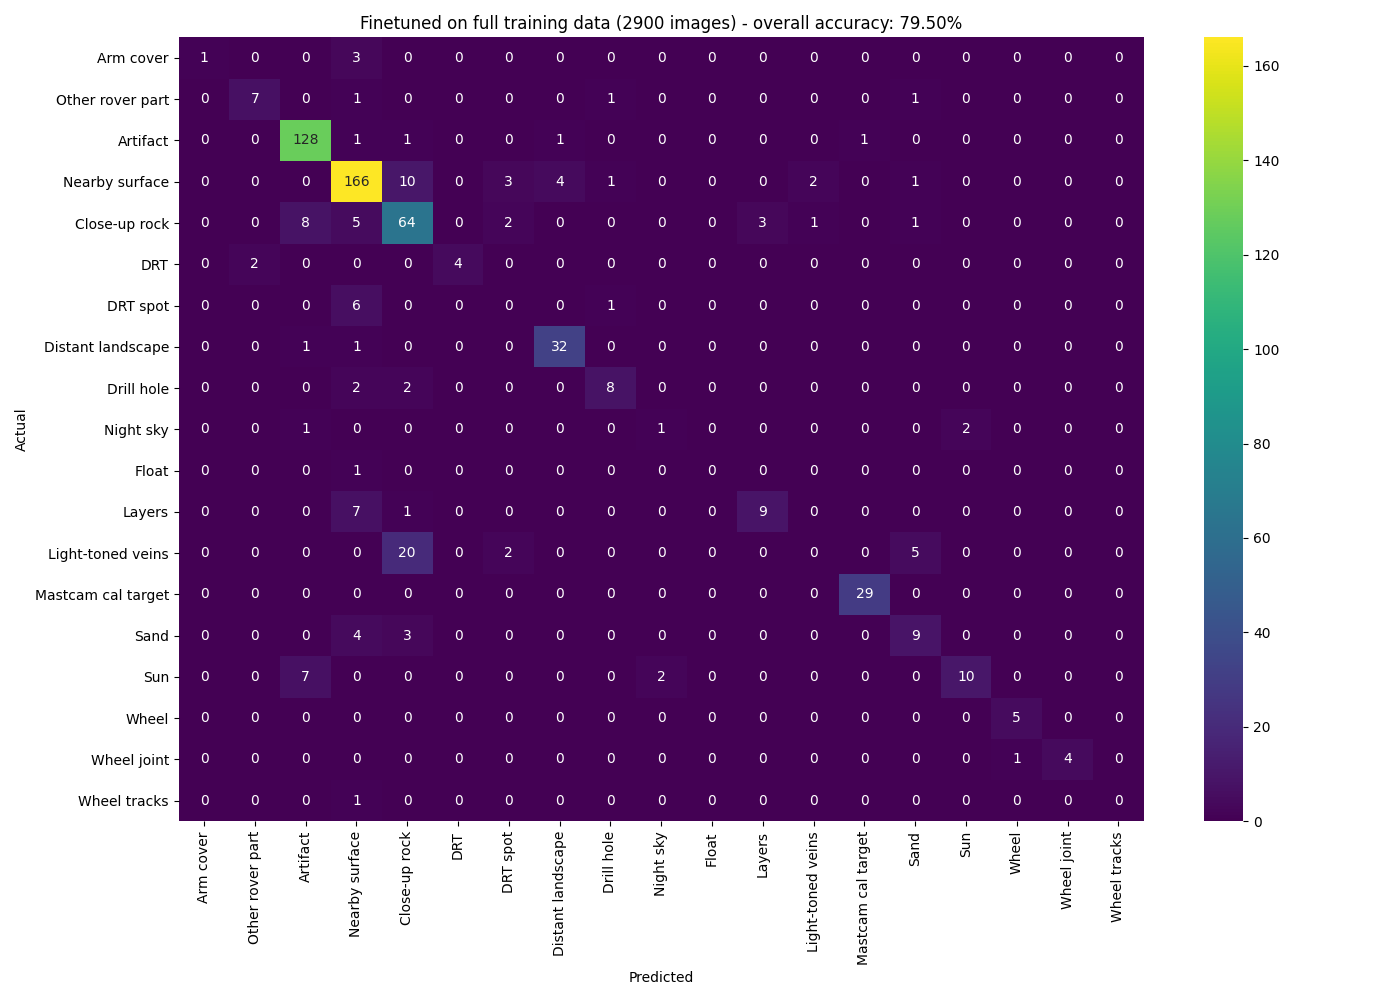

<IPython.core.display.Javascript object>


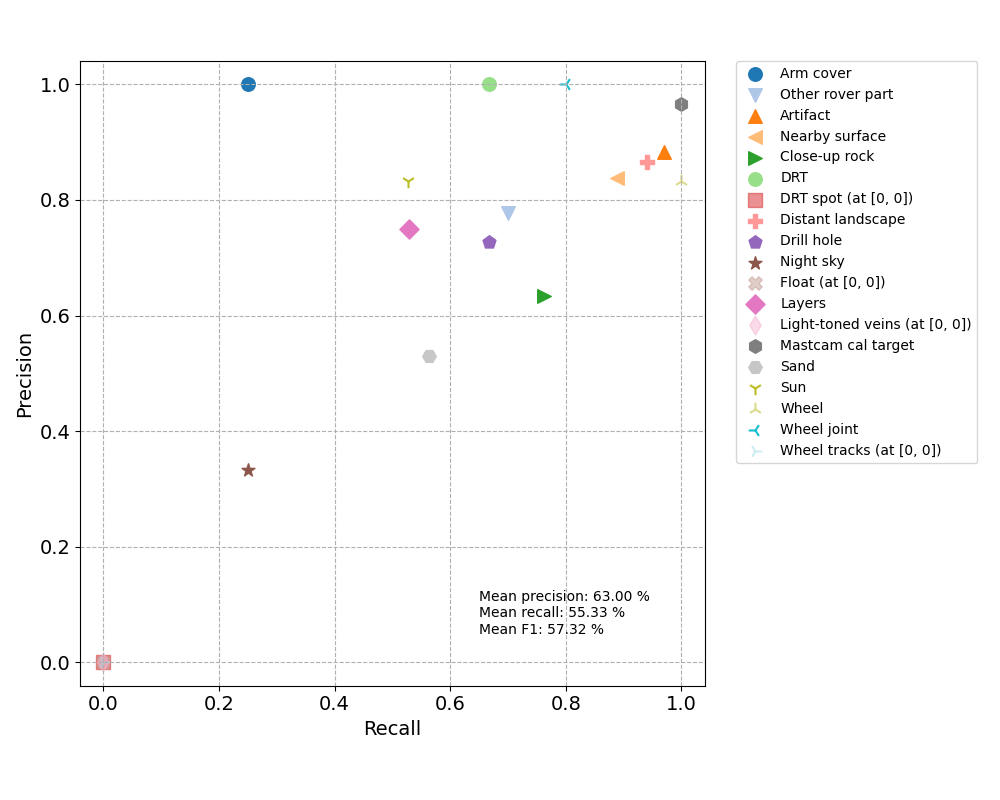

/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-41
 acc = 79.50
 mean_precision = 63.00
mean_recall = 55.33

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-42
Performing eval at step 0
{'eval/supervised_loss': 1.2103564, 'eval/label_top_1_accuracy': 0.77166665, 'eval/label_top_5_accuracy': 0.96666664, 'global_step': 0}


<IPython.core.display.Javascript object>


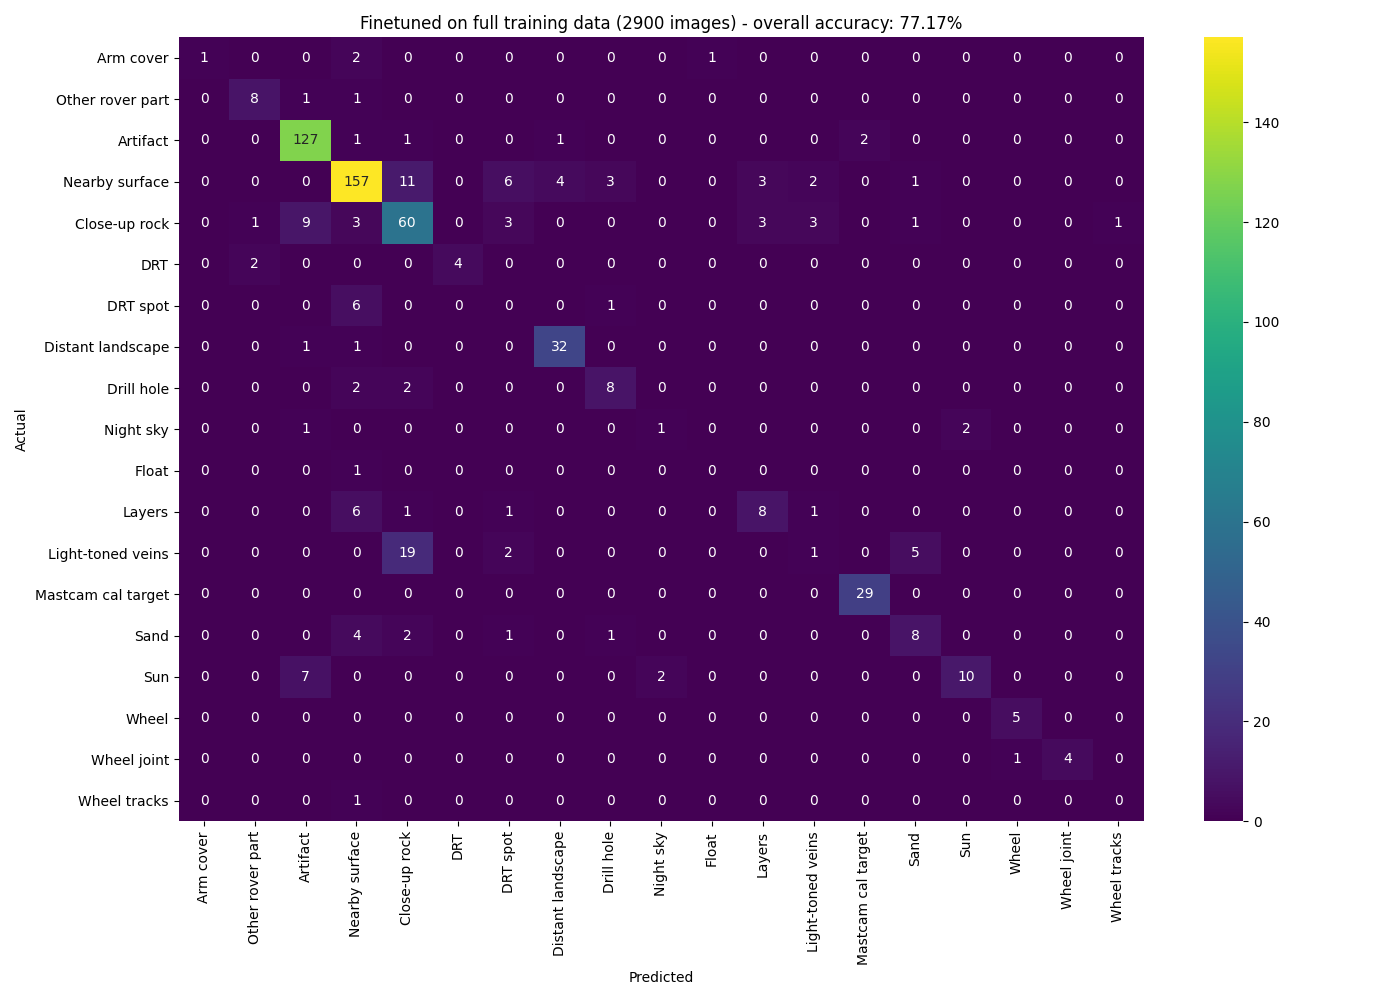

<IPython.core.display.Javascript object>


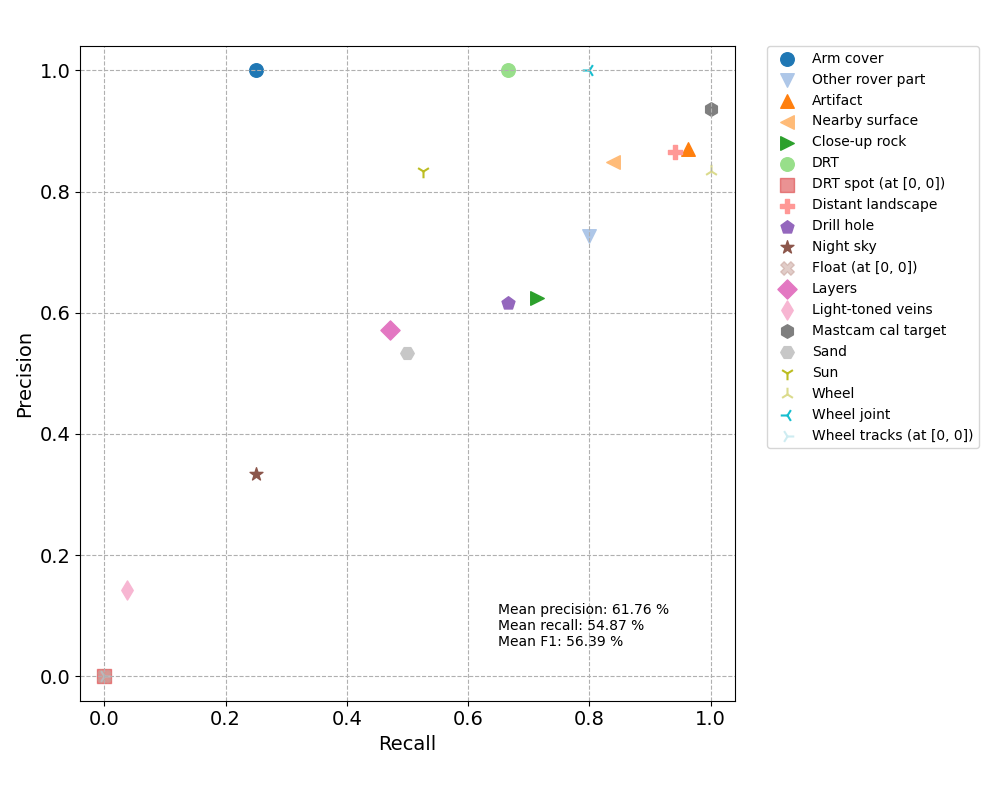

ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-42
 acc = 77.17
 mean_precision = 61.76
mean_recall = 54.87

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-43
Performing eval at step 0
{'eval/supervised_loss': 1.1888653, 'eval/label_top_1_accuracy': 0.7916667, 'eval/label_top_5_accuracy': 0.96666664, 'global_step': 0}


<IPython.core.display.Javascript object>


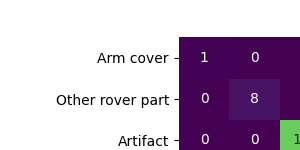

<IPython.core.display.Javascript object>


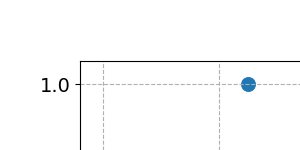

/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-43
 acc = 79.17
 mean_precision = 62.50
mean_recall = 55.35

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-44
Performing eval at step 0
{'eval/supervised_loss': 1.2066356, 'eval/label_top_1_accuracy': 0.7866667, 'eval/label_top_5_accuracy': 0.96166664, 'global_step': 0}


<IPython.core.display.Javascript object>


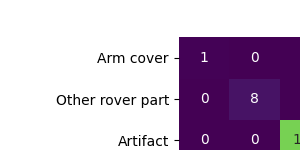

<IPython.core.display.Javascript object>


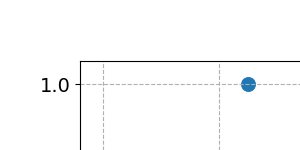

/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-44
 acc = 78.67
 mean_precision = 62.61
mean_recall = 55.64

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-45
Performing eval at step 0
{'eval/supervised_loss': 1.2034688, 'eval/label_top_1_accuracy': 0.79, 'eval/label_top_5_accuracy': 0.9683333, 'global_step': 0}


<IPython.core.display.Javascript object>


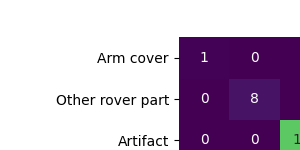

<IPython.core.display.Javascript object>


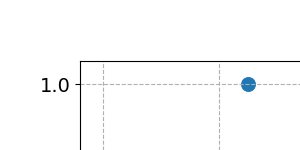

/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/goh/anaconda3/envs/tf2_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ckpt = /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-45
 acc = 79.00
 mean_precision = 61.64
mean_recall = 54.51

Restoring from /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-46


NotFoundError: Could not find checkpoint or SavedModel at /home/goh/Documents/D3M/mars_simclr_models/finetune_mars_v2_weighted_loss_r152_2x_sk1_proj128_3projLayers_2021-07-27_0718/ckpt-46.

In [9]:
logdir = os.path.join('/home/goh/Documents/tensorboard', log_name, 'eval')


outputs = []
for n in range(26,40):  # remember to change this to match ckpt nums
    ckpt = os.path.join(model_dir, f'ckpt-{n}')
    with tf.device('/gpu:0'):
        logits, predictions, labels = perform_evaluation(model, test_ds, num_classes, ckpt, logdir, strategy=None, batch_size=64)
    
    # plot results
    y_true = [classes[l] for l in labels]
    y_pred = [classes[p] for p in predictions]
    fig1, ax1, cm, acc = plot_confusion_matrix(y_true, y_pred, ckpt)
    fig2, ax2, cr_df, prec, recall = plot_precision_vs_recall(y_true, y_pred, ckpt)
    outputs.append((ckpt, acc, cm, cr_df, prec, recall))
    print(
        f"ckpt = {ckpt}\n",
        f"acc = {100*acc:.2f}\n",
        f"mean_precision = {100 * prec:.2f}\n"
        f"mean_recall = {100 * recall:.2f}\n"
    )
    

In [9]:
res_df = pd.DataFrame.from_records(
    [(o[0].split('/')[-1], o[1], o[4], o[5]) for o in outputs],
    columns=['ckpt', 'acc', 'prec', 'recall']
).sort_values(by='recall', ascending=False)

res_df.to_csv(os.path.join(model_dir, "results.csv"))

res_df

,ckpt,acc,prec,recall
10,ckpt-58,0.033333,0.036606,0.030838
8,ckpt-56,0.031667,0.032217,0.030556
3,ckpt-51,0.036667,0.037502,0.030205
5,ckpt-53,0.035000,0.029272,0.029923
6,ckpt-54,0.033333,0.026267,0.029524
9,ckpt-57,0.033333,0.034070,0.029290
11,ckpt-59,0.035000,0.037199,0.028539
1,ckpt-49,0.035000,0.029051,0.027226
12,ckpt-60,0.028333,0.030132,0.027062
13,ckpt-61,0.028333,0.027797,0.027062


In [9]:
pd.DataFrame.from_records(
    [(o[0].split('/')[-1], o[1], o[4], o[5]) for o in outputs],
    columns=['ckpt', 'acc', 'prec', 'recall']
).sort_values(by='recall', ascending=False)

,ckpt,acc,prec,recall
14,ckpt-169,0.556667,0.579164,0.573807
13,ckpt-168,0.535000,0.572226,0.567032
7,ckpt-162,0.546667,0.570333,0.563951
1,ckpt-156,0.560000,0.573856,0.563059
11,ckpt-166,0.520000,0.565205,0.561828
0,ckpt-155,0.555000,0.575086,0.558150
9,ckpt-164,0.545000,0.563364,0.557135
10,ckpt-165,0.538333,0.557652,0.555892
6,ckpt-161,0.536667,0.565783,0.551444
2,ckpt-157,0.545000,0.567828,0.548959
